# Image Classification Challenges - ANN2DL Polimi 2021-2022

## Notebook Settings


### Import Libraries

In [2]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)


### Seed for Reproducibility

In [7]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Dataset

In [8]:
dataset_dir = 'training'

In [9]:
input_folder='training'
splitfolders.ratio(input_folder,output="Leaves",seed=seed, ratio=(.8,.1,.1),group_prefix=None)

Copying files: 11203 files [00:03, 3620.53 files/s]


In [10]:
dataset_dir = 'Leaves'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

### Data Augmentation

In [12]:
aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255.) 

train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, 
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)

Found 8956 images belonging to 14 classes.


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


valid_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)


valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, 
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(256,256),
                                              color_mode='rgb',
                                              classes=None, 
                                              class_mode='categorical',
                                              batch_size=8,
                                              shuffle=False,
                                              seed=seed)

Found 1113 images belonging to 14 classes.
Found 1134 images belonging to 14 classes.


In [14]:
print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}

Target classes
[ 0  0  0 ... 13 13 13]


## Model

In [15]:
input_shape = (256, 256, 3)
epochs = 500

In [16]:
model = tfk.models.Sequential()
model.add(tfkl.GaussianNoise(0.07))
model.add(tfkl.Conv2D(filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)))

model.add(tfkl.BatchNormalization())
model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))
model.add(tfkl.BatchNormalization())
          
model.add(tfkl.Conv2D(filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)))
          
model.add(tfkl.BatchNormalization())
model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))
model.add(tfkl.BatchNormalization())
          
model.add(tfkl.Conv2D(filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)))

model.add(tfkl.BatchNormalization())
model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))
model.add(tfkl.BatchNormalization())
          
model.add(tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)))
          
model.add(tfkl.BatchNormalization())
model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))
model.add(tfkl.BatchNormalization())
          
          
model.add(tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)))

model.add(tfkl.BatchNormalization())
model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))
model.add(tfkl.BatchNormalization())
          
          
               
model.add(tfkl.Flatten())
model.add(tfkl.Dropout(0.3, seed=seed))
model.add(tfkl.Dense(units=512, name='Classifier', activation='relu',
                                  kernel_initializer=tfk.initializers.GlorotUniform(seed),
                                  kernel_regularizer=tf.keras.regularizers.l2(1e-5)))
model.add(tfkl.BatchNormalization())
model.add(tfkl.Dropout(0.3, seed=seed))
model.add(tfkl.Dense(units=14, activation='softmax', name='Output',kernel_initializer=tfk.initializers.GlorotUniform(seed),
                              kernel_regularizer=tf.keras.regularizers.l2(1e-5)))
          

learning_rate = 1e-3
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics='accuracy')


In [17]:
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)],
).history

Epoch 1/500
1120/1120 [==============================] - 105s 93ms/step - loss: 2.2534 - accuracy: 0.3450 - val_loss: 2.8796 - val_accuracy: 0.3208
Epoch 2/500
1120/1120 [==============================] - 102s 91ms/step - loss: 1.6853 - accuracy: 0.4713 - val_loss: 2.6170 - val_accuracy: 0.3783
Epoch 3/500
1120/1120 [==============================] - 102s 91ms/step - loss: 1.4925 - accuracy: 0.5360 - val_loss: 1.5006 - val_accuracy: 0.6065
Epoch 4/500
1120/1120 [==============================] - 102s 91ms/step - loss: 1.2643 - accuracy: 0.6122 - val_loss: 0.9788 - val_accuracy: 0.7125
Epoch 5/500
1120/1120 [==============================] - 104s 92ms/step - loss: 1.2006 - accuracy: 0.6468 - val_loss: 0.8936 - val_accuracy: 0.7691
Epoch 6/500
1120/1120 [==============================] - 102s 91ms/step - loss: 1.1629 - accuracy: 0.6752 - val_loss: 0.6719 - val_accuracy: 0.8329
Epoch 7/500
1120/1120 [==============================] - 103s 92ms/step - loss: 1.0867 - accuracy: 0.7086 - val_

In [22]:
model.save("Homework1/BestModel8.0")

INFO:tensorflow:Assets written to: Homework1/BestModel11.0/assets


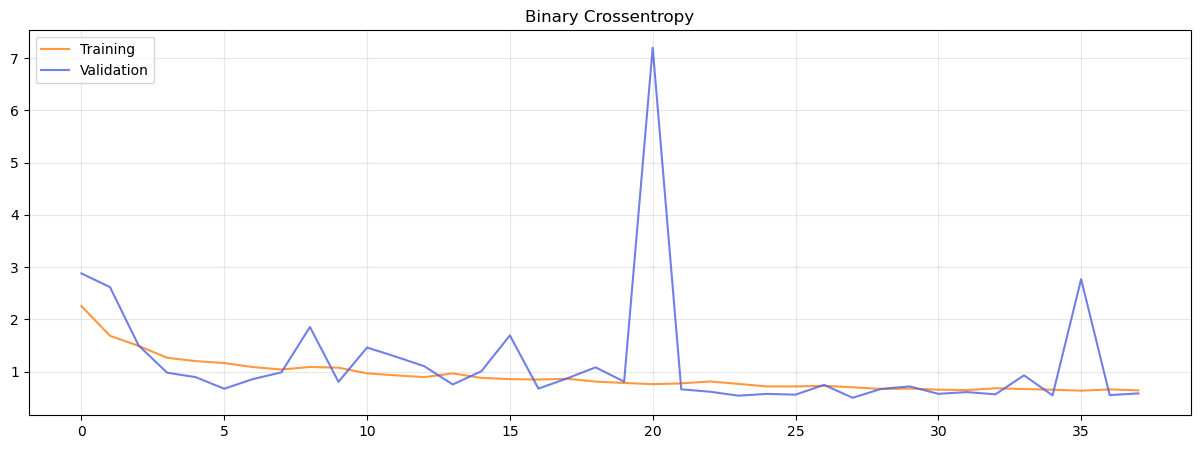

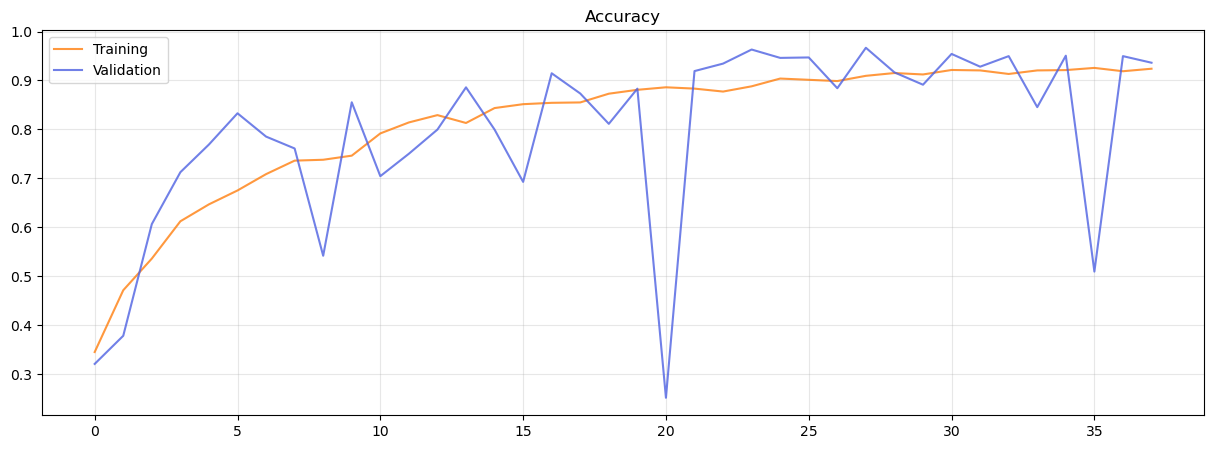

In [19]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [20]:
predictions = model.predict(test_gen)
predictions.shape

(1134, 14)

In [21]:
model_metrics = model.evaluate(test_gen, return_dict=True)
print()
print("Test metrics ")
print(model_metrics)

142/142 [==============================] - 3s 21ms/step - loss: 0.5019 - accuracy: 0.9727

Test metrics 
{'loss': 0.5019019842147827, 'accuracy': 0.972663164138794}
